In [9]:
import sys
sys.path.insert(0, '../mnist')
from mnistDataLoader import MnistDataloader

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from gan import Generator, Discriminator

In [10]:
NGPU = 1
device = torch.device("cuda:0" if (torch.cuda.is_available()) and NGPU>0 else "cpu")
print(device)

cuda:0


In [11]:
DATA_DIR = "./data"
DATALOAD_THREADS = 2
BATCH_SIZE = 128
# Also size of feature maps for generator and discriminator
IMG_SIZE = 64
# Size of z latent vector / generator input
Z_SIZE = 100

EPOCHS = 10
LR = 0.0002

# hyperparameter for Adam optimizers
BETA1 = 0.5
NGPU = 1

In [12]:
mnistDataSet = dset.MNIST('../mnist', download=True, transform=transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)),
]))

In [13]:
dataloader = torch.utils.data.DataLoader(mnistDataSet, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=DATALOAD_THREADS)

In [23]:
netG = Generator(NGPU, IMG_SIZE, 1, Z_SIZE).to(device)
netD = Discriminator(NGPU, IMG_SIZE, 1).to(device)

if (device.type == 'cuda') and (NGPU > 1):
    netG = nn.DataParallel(netG, list(range(NGPU)))
    netD = nn.DataParallel(netD, list(range(NGPU)))

print(netG)
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()


RuntimeError: Given groups=1, weight of size [128, 1, 4, 4], expected input[2, 3, 128, 128] to have 1 channels, but got 3 channels instead

In [15]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, Z_SIZE, 1, 1, device=device)

REAL = 1.
FAKE = 0.

optimizerD = optim.Adam(netD.parameters(), lr=LR, betas=(BETA1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LR, betas=(BETA1, 0.999))

In [19]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

for epoch in range(EPOCHS):
    # batches dataloader
    for batch_index, batch in enumerate(dataloader):

        # Discriminator training: maximizes log(D(x)) + log(1 - D(G(z)))
        def discriminatorLoss(realPreds, fakePreds):
            return -torch.mean(torch.log(realPreds) + torch.log(1 - fakePreds))
        
        # train with real batch from training data
        netD.zero_grad()
        real_cpu = batch[0].to(device) 
        b_size = real_cpu.size(0)

        realPreds = netD(real_cpu).view(-1)
        D_x = realPreds.mean().item()

        # train with generated batch from G
        z = torch.randn(b_size, Z_SIZE, 1, 1, device=device)
        fake = netG(z)
        fakePreds = netD(fake.detach()).view(-1)
        D_G_z1 = fakePreds.mean().item()

        # updates D
        lossD = discriminatorLoss(realPreds, fakePreds)
        lossD.backward()
        optimizerD.step()

        # Generator training: maximize log(D(G(z)))
        def generatorLoss(fakePreds):
            return -torch.mean(torch.log(fakePreds))
        
        netG.zero_grad()

        fakePreds = netD(fake).view(-1)
        D_G_z2 = fakePreds.mean().item()

        # updates G
        lossG = generatorLoss(fakePreds)
        lossG.backward()
        optimizerG.step()

        if batch_index % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, EPOCHS, batch_index, len(dataloader),
                     lossD.item(), lossG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(lossG.item())
        D_losses.append(lossD.item())

        # Check generator's progress accuracy fixed noise
        if (batch_index % 500 == 0) or ((epoch == EPOCHS-1) and (batch_index == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            

Starting Training Loop...
torch.Size([128, 1, 5, 5])


RuntimeError: The size of tensor a (5) must match the size of tensor b (128) at non-singleton dimension 3

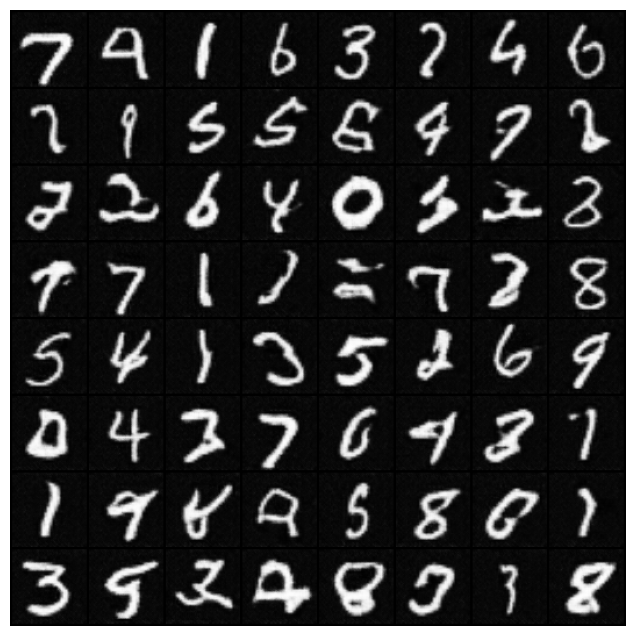

In [ ]:
from IPython.display import HTML
import matplotlib.animation as animation
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
matplotlib.rcParams['animation.embed_limit'] = 24

HTML(ani.to_jshtml())